In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
# Checkout the labels of the SST Data
data = pd.read_csv("drive/My Drive/Ceylon Surfers/Arugam Bay Mean Daily SST(2020-24).csv")

In [236]:
print(data.describe())

               SST
count  1827.000000
mean   2901.810755
std      79.022504
min    2703.322581
25%    2845.394803
50%    2901.753798
75%    2965.490248
max    3045.766667


In [237]:
print(data.head())

         Date          SST
0  2020-01-01  2814.193548
1  2020-01-02  2814.717894
2  2020-01-03  2815.242240
3  2020-01-04  2815.766587
4  2020-01-05  2816.290933


In [238]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
sst = data['SST'].astype(float).values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(sst)

Creating Sequences and Train-Test Split

In [239]:
window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Building the LSTM Model

In [240]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=128))
# model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer, loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [241]:
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0869 - val_loss: 0.0014
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 9.9272e-04
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 9.2126e-04
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 7.5932e-04
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 6.7543e-04
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2083e-04 - val_loss: 3.5955e-04
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7562e-04 - val_loss: 2.9215e-04
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9908e-04 - val_loss: 1.4791e-04
Epoch 12/200
73/73 ━━

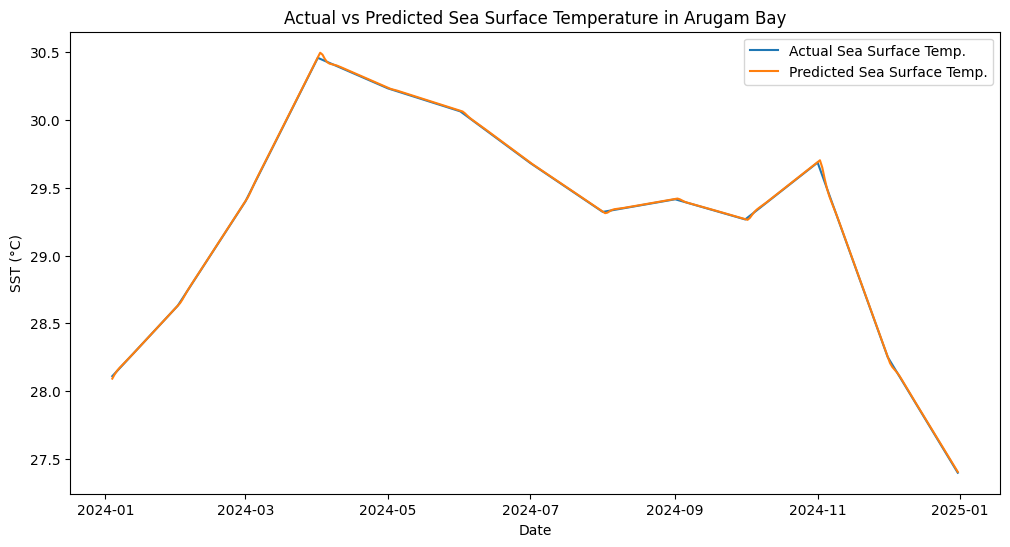

In [242]:
# Plotting with Converted Temperature Scale
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test / 100, label='Actual Sea Surface Temp.')
plt.plot(dates_test, predictions / 100, label='Predicted Sea Surface Temp.')
plt.title('Actual vs Predicted Sea Surface Temperature in Arugam Bay')
plt.xlabel('Date')
plt.ylabel('SST (°C)')
plt.legend()
plt.show()